### Data Manipulation with PySparks

Grab a PARQUET file and create a dataframe out of it.

In [1]:
import pyspark.sql.functions

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20191216093958-0000
KERNEL_ID = 736cf0a9-0a11-4a76-9c77-761c9a0bcdf9


In [2]:
!wget https://github.com/rahulsnair/sample_parquet/blob/master/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2019-12-16 09:40:01--  https://github.com/rahulsnair/sample_parquet/blob/master/washing.parquet?raw=true
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/rahulsnair/sample_parquet/raw/master/washing.parquet [following]
--2019-12-16 09:40:01--  https://github.com/rahulsnair/sample_parquet/raw/master/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rahulsnair/sample_parquet/master/washing.parquet [following]
--2019-12-16 09:40:01--  https://raw.githubusercontent.com/rahulsnair/sample_parquet/master/washing.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response

In [3]:
# returns minimum temperature
def minTemperature(df,spark):
    return spark.sql("SELECT MIN(temperature) as mintemp from washing").first().mintemp

In [4]:
# return mean temperature
def meanTemperature(df,spark):
    return spark.sql("SELECT MEAN(temperature) as meantemp from washing").first().meantemp

In [5]:
# return max temperature
def maxTemperature(df,spark):
    return spark.sql("SELECT MAX(temperature) as maxtemp from washing").first().maxtemp

The standard deviation of the temperature

In [6]:
def sdTemperature(df,spark):
    return spark.sql("SELECT stddev_pop(temperature) as sdtemp from washing").first().sdtemp

The skew of the temperature:

In [7]:
def skewTemperature(df,spark):    
    return spark.sql("""
SELECT 
    (
        1/COUNT(*)
    ) *
    SUM (
        POWER(temperature - %s, 3)/POWER(%s,3)
    )

as sktemperature from washing
                    """ %(meanTemperature(df,spark),sdTemperature(df,spark))).first().sktemperature

Kurtosis is the 4th statistical moment

In [8]:
def kurtosisTemperature(df,spark):    
        return spark.sql("""
SELECT 
    (
        1/COUNT(*)
    ) *
    SUM (
        POWER(temperature - %s, 4)/POWER(%s,4)
    )
as ktemperature from washing
                    """ %(meanTemperature(df,spark),sdTemperature(df,spark))).first().ktemperature


In [9]:
# returns correlation value
def correlationTemperatureHardness(df,spark):
    return spark.sql("SELECT corr(temperature,hardness) as temperaturehardness from washing").first().temperaturehardness

In [10]:
df = spark.read.parquet('washing.parquet')
df.createOrReplaceTempView('washing')
df.show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

let's test the functions

In [11]:
min_temperature = minTemperature(df,spark)
print(min_temperature)

80


In [12]:
mean_temperature = meanTemperature(df,spark)
print(mean_temperature)

90.03800298062593


In [13]:
max_temperature = maxTemperature(df,spark)
print(max_temperature)

100


In [14]:
sd_temperature = sdTemperature(df,spark)
print(sd_temperature)

6.098487624200337


In [15]:
skew_temperature = skewTemperature(df,spark)
print(skew_temperature)

0.006788255973582835


In [16]:
kurtosis_temperature = kurtosisTemperature(df,spark)
print(kurtosis_temperature)

1.158158434967638


In [17]:
correlation_temperature = correlationTemperatureHardness(df,spark)
print(correlation_temperature)

0.017754069047296324


In [18]:
result = spark.sql("SELECT voltage FROM washing WHERE voltage is not null")
voltages = result.rdd.map(lambda row: row.voltage).sample(False, 0.1).collect()

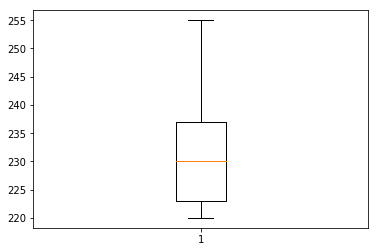

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.boxplot(voltages)
plt.show()

In [20]:
result = spark.sql("SELECT voltage,ts FROM washing WHERE voltage is not null ORDER BY ts")
result_rdd = result.rdd.map(lambda row: (row.ts,row.voltage)).sample(False, 0.1)

In [21]:
result_array_ts = result_rdd.map(lambda x: x[0]).collect()
result_array_vol = result_rdd.map(lambda x: x[1]).collect()

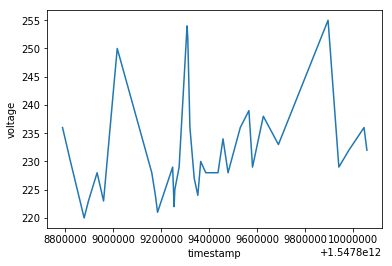

In [22]:
plt.plot(result_array_ts,result_array_vol)
plt.xlabel("timestamp")
plt.ylabel("voltage")
plt.show()

In [23]:
result = spark.sql("SELECT hardness,temperature,flowrate FROM washing WHERE hardness is not null AND temperature is not null AND flowrate is not null")
result_rdd = result.rdd.sample(False, 0.1).map(lambda row: (row.hardness,row.temperature, row.flowrate))

In [24]:
result_array_hardness = result_rdd.map(lambda x: x[0]).collect()
result_array_temp = result_rdd.map(lambda x: x[1]).collect()
result_array_flow = result_rdd.map(lambda x: x[2]).collect()

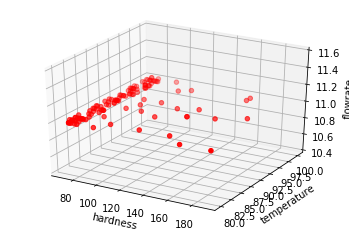

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result_array_hardness,result_array_temp,result_array_flow,c='r', marker='o')
ax.set_xlabel('hardness')
ax.set_ylabel('temperature')
ax.set_zlabel('flowrate')

plt.show()

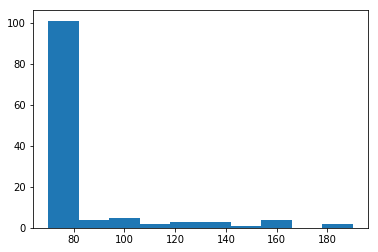

In [26]:
plt.hist(result_array_hardness)
plt.show()